# Classification of MNIST

MNIST is a dataset consisting of handwritten numbers 0-9 widely used as a benchmark in machine learning. While the dataset is very simple, it is still in seminal papers to demonstrate proof of concept (i.e. [Dynamic Routing](https://arxiv.org/pdf/1710.09829.pdf)). Below we load some sample digits for you.

Benchmark datasets are very useful, to note a couple other widely used benchmarks: [SVHN](http://ufldl.stanford.edu/housenumbers/) (Street View House Numbers), [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) (Like MNIST, but more fashion), [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) (10 and 100 different objects), and [ImageNet](http://www.image-net.org/) (very large real world image dataset).

We load up a downsampled MNIST dataset below. MNIST is usually 28x28, we will work with 8x8 images.

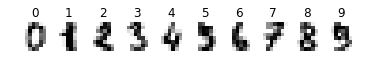

In [430]:
# Import datasets
%matplotlib inline

from sklearn import datasets
import matplotlib.pyplot as plt
digits = datasets.load_digits()
for index, (image, label) in enumerate(list(zip(digits.images, digits.target))[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('%i' % label)
plt.show()

# Part I

You will classifiy two numbers of your choice. Start by extracting two features from the image. We suggest looking at intensity and symmetry using `sklearn.model_selection.train_test_split`, a convenient function which will save 10% of the data for testing. We split the dataset into training and test sets. Save your test set so we can evaluate how well you classify.

`X_test` and `y_test` should be used to evaluate the performance of the classifier you build. Moving forward just work with `X_train` and `y_train`.

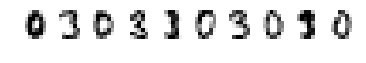

In [431]:
from sklearn.model_selection import train_test_split
import numpy as np

number_a = 0 # TODO choose your digit
number_b = 3# TODO choose your digit

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
for index, image in enumerate(X_train[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

# Feature Extraction

You will create 2 feature extractors based on the numbers you choose. These will be two functions which take in an image and output a single float. For example, image intensity and symmetry can be used as a features.

In [432]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    # get the symmetry
    def compute_feature_a(image):
        return np.mean(image*np.rot90(image, k = 2))
    # get the intensity
    def compute_feature_b(image):
        return np.mean(image)

    return compute_feature_a(image), compute_feature_b(image)

Once you compute these two features, you can apply them to your images. Don't worry about the details of the first function below, all it does is map the `compute_features` function you wrote to each image in your `X_train` variable.

Afterwards let us plot the features you've crafted to see if they can separate into two classes.

(4.0, 6.328125)

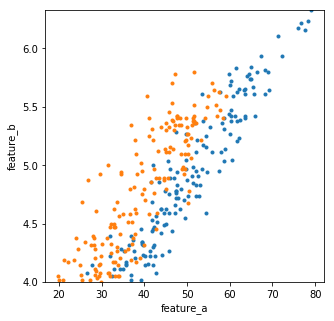

In [433]:
# Apply and plot your features

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

# Linear Classification with Pseudo Inverse

`X_features` is a 2 dimensional array of features and `y_train` is our ground truth label. Find the best plane that separates these two classes using the pseudo inverse and plot it. For this problem, we need to set `y=-1` for `number_a` and `y=1` for `number_b`.

The loss $L$ we would like to minimize for each $i$ row in our matrix is.

$$L  = \frac{1}{2}\Sigma (y^{(i)} - W^{T}x^{(i)})^{2}$$

where

$$x^{(i)} = 
\begin{bmatrix}
    feature_a \\
    feature_b \\
\end{bmatrix}$$

$$W = 
\begin{bmatrix}
    w_1 \\
    w_2 \\
\end{bmatrix}$$


In matrix form we convert $x^{(i)}$ into $X$ which is the number of examples we have, in our case is MNIST digit features extracted.

$$X = 
\begin{bmatrix}
    feature_{a1} & feature_{b1} \\
    feature_{a2} & feature_{b2} \\
    ... & ... \\
    feature_{ai} & feature_{bi} \\
\end{bmatrix}$$


$$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$


### Explain

Let's solve L analytically, set $\frac{d}{dW}L = 0$ and solve. Show your steps.

Step 1: $$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 2: $$ \frac{d}{dW}L  = \frac{d}{dW} \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 3: 
$$ \frac{d}{dW} \frac{1}{2}( Y-XW )^{T} (Y-XW) = 0$$

Step 4: 
$$ \frac{1}{2}( -W )^{T} (Y-XW) = 0$$


Step 5: 
$$ W^{T} (Y-XW) = 0 $$

Step 6: 
$$ (Y-XW) = 0 $$

Step 7: 
$$ W = (X^{T}X)^{-1}X^{T}Y $$





### Compute
Going back to linear algebra, we can re-write the classification problem as $Xw = y^*$, as we did during class. Here, $X$ is our features matrix `X_features` that has the features of each data example along each row, $y^*$ is our `pseudo_y` vector, and $w$ is the unknown weights vector that we'd like to figure out.

The pseudo inverse is $$(X^{T}X)^{-1}X^{T} = X^{+}$$

Solving for $w$, $$w = X^{+}y^*$$

To perform this computation: 

#### (a) create a features vector $X$ and compute its pseudo inverse. (This is the var `X_features`)


#### (b) create a vector like $y^*$ to hold the labels. (Done below for you as `pseudo_y`)

#### (c) find $w$

In [434]:
#a. 
X = np.copy(X_features)

#b. 
train_label = np.copy(y_train)
train_label[y_train == number_a] = -1
train_label[y_train == number_b] = 1

#c. 
w = np.linalg.pinv(X) @ train_label
print(w)
y_predicted_trained = X @ w


[-0.07897377  0.74632115]


In [6]:
# for test dataset
X_features_test = np.apply_along_axis(compute_features, 1, X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_features_a_test = X_features_test[np.where(y_test==number_a)]
X_features_b_test = X_features_test[np.where(y_test==number_b)]

#a. 
X_tested = np.copy(X_features_test)

#b. 
test_label = np.copy(y_test)
test_label[y_test == number_a] = -1
test_label[y_test == number_b] = 1

#c. 
y_predicted_tested = X_tested @ w

### (d) To examine the result of the least squares solution under this formulation, compute the train and test error using an appropriate threshold. Does your trained model generalize well to the test data? 

Create a function called `accuracy_metrics` which does this.

In [7]:
def accuracy_metrics(predicted, label):
    return np.mean((predicted > 0) == (label > 0))    
print('trained accuracy: ', accuracy_metrics(y_predicted_trained, train_label))
print('tested accuracy: ', accuracy_metrics(y_predicted_tested, test_label))

trained accuracy:  0.7623456790123457
tested accuracy:  0.8648648648648649


In [8]:
def visualize_model(features, labels, weights, y):
    a = np.linspace(0, 250, num = 100)
    if len(weights) == 2:
        b = - weights[0] * a / weights[1] # add weights[2] into formula
    elif len(weights) == 3:
        b = - (weights[0] * a + weights[2]) / weights[1]    
    features_a = features[np.where(y==number_a)]
    features_b = features[np.where(y==number_b)]
    plt.figure(figsize=(5,5))
    plt.plot(features_a[:, 0], features_a[:, 1], '.')
    plt.plot(features_b[:, 0], features_b[:, 1], '.')
    plt.plot(a, b)
    plt.xlabel('feature_a')
    plt.ylabel('feature_b')
    plt.ylim(features[:, 1].min(), features[:, 1].max()) 

[-0.07897377  0.74632115]


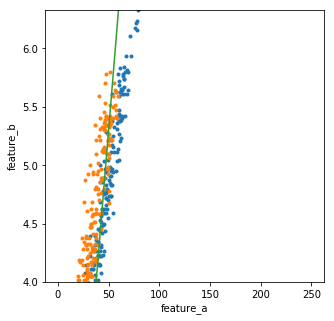

In [9]:
visualize_model(X_features, train_label, w, y_train)
print(w)

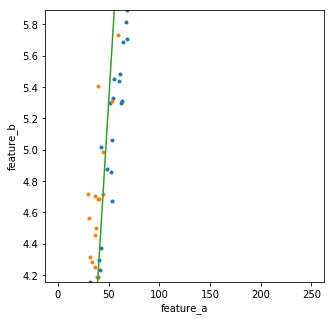

In [10]:
 visualize_model(X_features_test, test_label, w, y_test)

### (f) Repeat the above steps after adding in a bias term, allowing for the classification line to not pass through the origin. You can do this by augmenting the X feature matrix with an additional feature column of ones, and making the unknown weight vector one entry longer -- does performance improve?

If you created your functions correctly, you shouldn't need to change them and you only need to modify `X_features`. 

### (e) Write a function that visualizes the decision boundary corresponding to your chosen threshold (you can either draw a line or shade the region above/below the threshold). 

The function `visualize_model` should take in features, labels, and your calculated weights. It should show a matplotlib figure.

[-0.10825455  1.71069383 -3.39725453]
0.8425925925925926


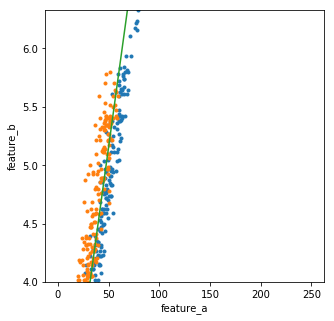

In [11]:
# Find w and bias
#a. 
X = np.copy(X_features)
bias = np.ones([len(X), 3])
bias[:,:-1] = X
X_bias = bias
# print(X_bias)

#b. 
train_label = np.copy(y_train)
train_label[y_train == number_a] = -1
train_label[y_train == number_b] = 1

#c. 
w_bias = np.linalg.pinv(X_bias) @ train_label
print(w_bias)
y_predicted_trained = X_bias @ w_bias

# Get the test and train accuracy of your model with bias
print(accuracy_metrics(y_predicted_trained, train_label))
# print(accuracy_metrics(y_predicted_tested, test_label))

# Visualize the model, you may need to change your code.
visualize_model(X_bias, train_label, w_bias, y_train)


In [12]:
# The performance should improve

# Linear Classification with Finite Differences

Rather than use pseudo inverse (analytically solving your optimization equation). Instead, initialize your parameter x to some random numbers. Move x some small epsilon amount in the each direction to compute the total change in your loss and calculate the gradient. Then update x by taking a small step in that gradient direction. You can execute this in a for loop for a set number of iterations, or until the gradient reaches some threshold value of not changing very much.

1. Solve for x
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps

### Define a loss.

In [13]:
def loss(features, labels, weights):
    L = 0.5*np.matmul((labels - np.matmul(features,weights)).transpose(), (labels - np.matmul(features,weights)))
    return L / np.size(labels)

### Now iteratively solve for your weights w

In [14]:
def get_gradient(feature, label, weights, delta, L):
    delta_weights = np.copy(weights)
    gradient = [0, 0]
    delta_weights[0] = delta_weights[0] + delta
    new_loss1 = loss(feature, label, delta_weights)
    delta_loss1 = new_loss1 - L
    gradient[0] = delta_loss1 / delta
    
    delta_weights = np.copy(weights)
    delta_weights[1] = delta_weights[1] + delta
    new_loss2 = loss(feature, label, delta_weights)
    delta_loss2 = new_loss2 - L
    gradient[1] = delta_loss2 / delta
    return gradient / np.linalg.norm(gradient)

In [15]:
def get_weight(features, labels):
    w = np.random.rand(2) # init weights to some random value.
    num_iterations = 10000 #set this to the number of iterations
    delta = 1e-6 # This may need to be adjusted
    step_size = 1e-3
    for i in range(num_iterations):
        L = loss(features, labels, w)
        gradient = get_gradient(features, labels, w, delta, L)
        w -= step_size*gradient
        if (i % 1000 == 0):
            y_predicted = features @ w
            print("accuracy: ", accuracy_metrics(y_predicted, labels))      
    return w  

accuracy:  0.5154320987654321
accuracy:  0.7746913580246914
accuracy:  0.7623456790123457
accuracy:  0.7623456790123457
accuracy:  0.7623456790123457
accuracy:  0.7654320987654321
accuracy:  0.7654320987654321
accuracy:  0.7654320987654321
accuracy:  0.7654320987654321
accuracy:  0.7654320987654321


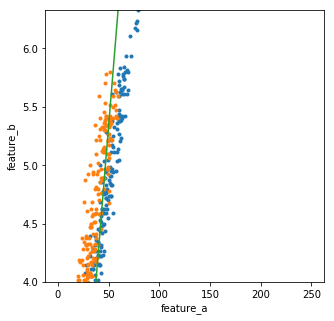

In [16]:
weight_numerical_train = get_weight(X_features, train_label)
visualize_model(X_features, train_label, weight_numerical_train, y_train)

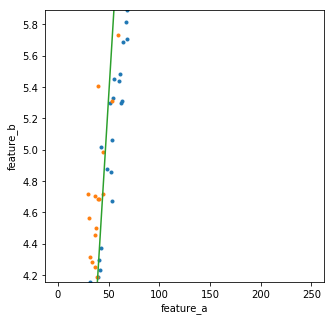

In [17]:
visualize_model(X_features_test, test_label, weight_numerical_train, y_test)

# Logistic Classification with Finite Differences

Now, let's consider the same problem with a different loss function.

$$L = \frac{1}{N}\sum_{i=1}^n ln(1 + e^{-y^{(i)}W^{T}x^{(i)}})$$

Use finite differences to compute the gradient and iteratively calculate $W$

1. Solve for x
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps


In [351]:
logistic_y_train = np.copy(y_train)
logistic_y_train[y_train == number_a] = 0
logistic_y_train[y_train == number_b] = 1

In [352]:
def logistic_loss(features, labels, weights):
    return np.sum(np.log(1 + np.exp(-labels * np.matmul(features, weights.transpose())))) / features.shape[1]

In [358]:
def get_gradient_log(feature, label, weight, delta, L):
    delta_weights = np.copy(weight)
    gradient = [0, 0]
    delta_weights[0] = delta_weights[0] + delta
    new_loss1 = logistic_loss(feature, label, delta_weights)
    delta_loss1 = new_loss1 - L
    gradient[0] = delta_loss1 / delta
    
    delta_weights = np.copy(weight)
    delta_weights[1] = delta_weights[1] + delta
    new_loss2 = logistic_loss(feature, label, delta_weights)
    delta_loss2 = new_loss2 - L
    gradient[1] = delta_loss2 / delta
    return gradient / np.linalg.norm(gradient)

In [367]:
def get_weight(features, labels):
    w = np.random.rand(2) # init weights to some random value.
    num_iterations = 200000 #set this to the number of iterations
    delta = 1e-8 # This may need to be adjusted
    step_size = 1e-2
    for i in range(num_iterations):
        log_loss = logistic_loss(features, labels, w)
        gradient = get_gradient(features, labels, w, delta, log_loss)
        w -= step_size*gradient
        if (i % 20000 == 0):
            y_predicted = features @ w
            print("accuracy: ", accuracy_metrics(y_predicted, labels))      
    return w 

In [372]:
weight_numerical_train = get_weight(X_features, logistic_y_train)

accuracy:  0.5093167701863354
accuracy:  0.8944099378881988
accuracy:  0.8944099378881988
accuracy:  0.8944099378881988
accuracy:  0.8944099378881988
accuracy:  0.8944099378881988
accuracy:  0.8944099378881988
accuracy:  0.8944099378881988
accuracy:  0.8944099378881988
accuracy:  0.8944099378881988


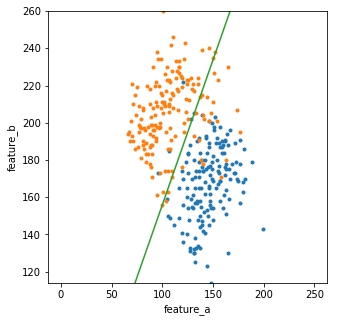

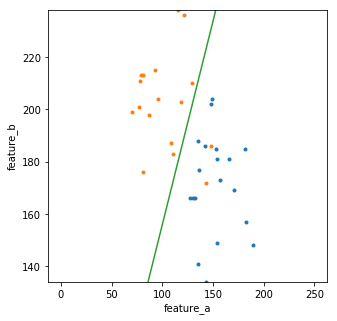

In [374]:
visualize_model(X_features, logistic_y_train, weight_numerical_train, y_train)
visualize_model(X_features_test, logistic_y_train, weight_numerical_train, y_test)

# Part II

Now let’s repeat the exercise above, but using a different set of features. Here, let’s assume that we have a camera that has just two pixels in it, which is taking pictures of the MNIST image dataset. One of these two pixels will detect the total intensity from the top half of each digit to form feature x_1, and the other pixel will detect the total intensity from the bottom half of each digit to form feature x_2. Please use these two top/bottom total intensities to form a new feature vector for each MNIST image that you’re using for classification, and repeat the exercise above to obtain a plot of classification performance and an average classification accuracy score. 

**Note that this classification score (in some sense) reflects what would be possible with a "normal" camera.**

 - Plot Points after feature generation
 - Linear Classification (Pseudo or Gradient method)
   - test/train accuracy
 - Logistic Classification
   - test/train accuracy

In [377]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        sum_image = image.sum(axis=1)
        return sum_image[0] + sum_image[1] + sum_image[2] + sum_image[3]
    def compute_feature_b(image):
        sum_image = image.sum(axis=1)
        return sum_image[4] + sum_image[5] + sum_image[6] + sum_image[7]  
    return compute_feature_a(image), compute_feature_b(image)

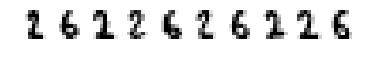

In [378]:
from sklearn.model_selection import train_test_split
import numpy as np

number_a = 2 # TODO choose your digit
number_b = 6# TODO choose your digit

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
for index, image in enumerate(X_train[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

(114.0, 260.0)

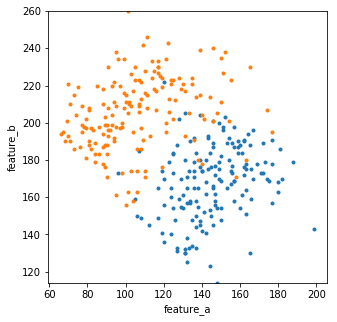

In [379]:
X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

[-0.02120679  0.01439845]
[-0.01866483  0.01258439]
trained accuracy:  0.9316770186335404
tested accuracy:  0.9444444444444444


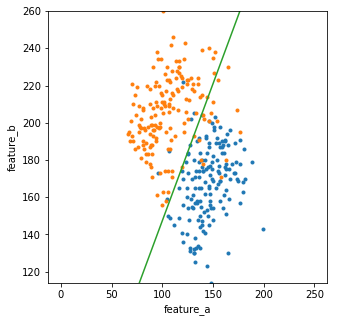

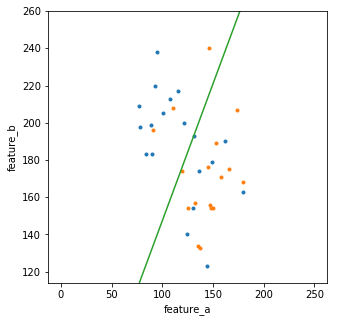

In [380]:
# linear:
#a. 
X = np.copy(X_features)

#b. 
train_label = np.copy(y_train)
train_label[y_train == number_a] = -1
train_label[y_train == number_b] = 1

#c. 
w = np.linalg.pinv(X) @ train_label
print(w)
y_predicted_trained = X @ w


# for test dataset
X_features_test = np.apply_along_axis(compute_features, 1, X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_features_a_test = X_features_test[np.where(y_test==number_a)]
X_features_b_test = X_features_test[np.where(y_test==number_b)]

#a. 
X_tested = np.copy(X_features_test)

#b. 
test_label = np.copy(y_test)
test_label[y_test == number_a] = -1
test_label[y_test == number_b] = 1

#c. 
w_test = np.linalg.pinv(X_tested) @ test_label
print(w_test)
y_predicted_tested = X_tested @ w_test


print('trained accuracy: ', accuracy_metrics(y_predicted_trained, train_label))
print('tested accuracy: ', accuracy_metrics(y_predicted_tested, test_label))

# visualization
visualize_model(X_features, train_label, w, y_train)
visualize_model(X_features, test_label, w, y_test)


accuracy:  0.5093167701863354
accuracy:  0.5093167701863354
accuracy:  0.5093167701863354
accuracy:  0.5093167701863354
accuracy:  0.5093167701863354
accuracy:  0.5093167701863354
accuracy:  0.546583850931677
accuracy:  0.9192546583850931
accuracy:  0.922360248447205
accuracy:  0.9285714285714286


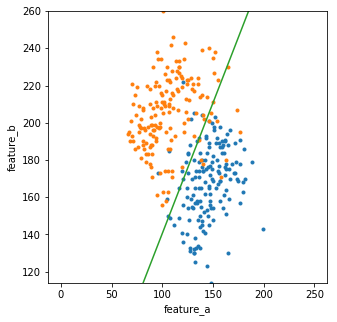

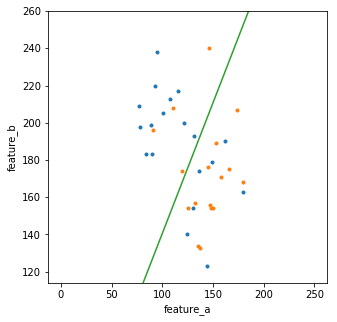

In [394]:
# logical regression
logistic_y_train2 = np.copy(y_train)
logistic_y_train2[y_train == number_a] = 0
logistic_y_train2[y_train == number_b] = 1

logistic_y_test2 = np.copy(y_test)
logistic_y_test2[y_test == number_a] = 0
logistic_y_test2[y_test == number_b] = 1

def get_weight_logistic(features, labels):
    weight_init = np.random.rand(2) # init weights to some random value.
    num_iterations = 100000 # set this to the number of iterations
    delta = 1e-5 # This may need to be adjusted
    step_size = 1e-5
    for i in range(num_iterations):
        log_loss = logistic_loss(features, labels, weight_init)
        gradient = get_gradient(features, labels, weight_init, delta, log_loss)
        weight_init -= step_size*gradient
        if (i % 10000 == 0):
            y_predicted = features@weight_init
            print("accuracy: ", accuracy_metrics(y_predicted, labels)) 
    return weight_init


weight_numerical_train = get_weight_logistic(X_features, logistic_y_train2)
visualize_model(X_features, logistic_y_train2, weight_numerical_train, y_train)
visualize_model(X_features, logistic_y_test2, weight_numerical_train, y_test)

# Part III

Finally, let’s assume that this camera has a special filter in its lens that blurs the MNIST image in a special way before it is detected. Let’s model this 2D blur as a convolution with the 3x3 filter below.

$$X = 
\begin{bmatrix}
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
\end{bmatrix}$$

Convolve the set of MNIST images with this kernel before proceeding to compute the two features of interest as in Part I: the total image intensity, and the image symmetry. Repeat the exercise above to obtain a plot of classification performance and an average classification accuracy score.

**Note that this classification score (in some sense) reflects what would be possible with a “computational” camera, which has a special aperture shape for enhanced image classification.**

 - Plot Points after feature generation
 - Linear Classification (Pseudo or Gradient method)
   - test/train accuracy
 - Logistic Classification
   - test/train accuracy

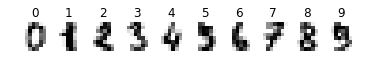

In [435]:
# Import datasets
%matplotlib inline

from sklearn import datasets
import matplotlib.pyplot as plt
digits = datasets.load_digits()
for index, (image, label) in enumerate(list(zip(digits.images, digits.target))[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('%i' % label)
plt.show()

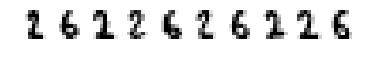

In [468]:
from sklearn.model_selection import train_test_split
import numpy as np

number_a = 2 # TODO choose your digit
number_b = 6 # TODO choose your digit

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
for index, image in enumerate(X_train[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

In [469]:
from scipy.signal import convolve

def compute_features(vector):
    c = [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]
    image = vector.reshape(8, 8) # get back original image shape
    image = convolve(image, np.abs(c), mode='same')
    def compute_feature_a(image):
        return np.mean(image*np.rot90(image, k = 2))
    def compute_feature_b(image):
        return np.mean(image)
    return compute_feature_a(image), compute_feature_b(image)

(20.8125, 35.0)

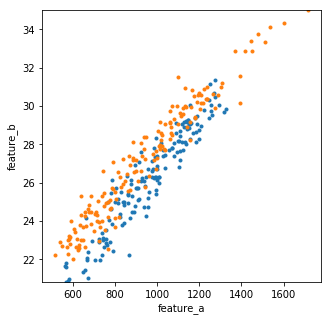

In [470]:
X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

trained accuracy:  0.5900621118012422
tested accuracy:  0.7222222222222222


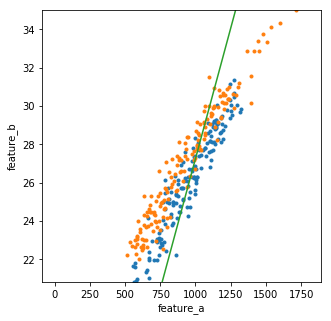

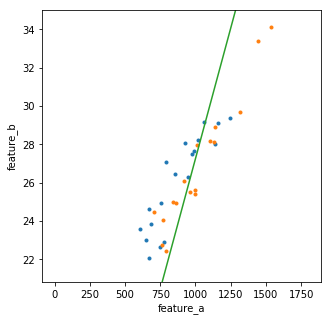

In [473]:
# linear:
#a. 
X = np.copy(X_features)

#b. 
train_label = np.copy(y_train)
train_label[y_train == number_a] = -1
train_label[y_train == number_b] = 1

#c. 
w = np.linalg.pinv(X) @ train_label
y_predicted_trained = X @ w


# for test dataset
X_features_test = np.apply_along_axis(compute_features, 1, X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_features_a_test = X_features_test[np.where(y_test==number_a)]
X_features_b_test = X_features_test[np.where(y_test==number_b)]

#a. 
X_tested = np.copy(X_features_test)

#b. 
test_label = np.copy(y_test)
test_label[y_test == number_a] = -1
test_label[y_test == number_b] = 1

#c. 
w_test = np.linalg.pinv(X_tested) @ test_label
y_predicted_tested = X_tested @ w_test

print('trained accuracy: ', accuracy_metrics(y_predicted_trained, train_label))
print('tested accuracy: ', accuracy_metrics(y_predicted_tested, test_label))

def visualize_model(features, labels, weights, y):
    a = np.linspace(0, 1800, num = 100)
    if len(weights) == 2:
        b = - weights[0] * a / weights[1] # add weights[2] into formula
    elif len(weights) == 3:
        b = - (weights[0] * a + weights[2]) / weights[1]    
    features_a = features[np.where(y==number_a)]
    features_b = features[np.where(y==number_b)]
    plt.figure(figsize=(5,5))
    plt.plot(features_a[:, 0], features_a[:, 1], '.')
    plt.plot(features_b[:, 0], features_b[:, 1], '.')
    plt.plot(a, b)
    plt.xlabel('feature_a')
    plt.ylabel('feature_b')
    plt.ylim(features[:, 1].min(), features[:, 1].max()) 


accuracy:  0.5093167701863354
accuracy:  0.593167701863354
accuracy:  0.593167701863354
accuracy:  0.593167701863354
accuracy:  0.593167701863354
accuracy:  0.593167701863354
accuracy:  0.593167701863354
accuracy:  0.593167701863354
accuracy:  0.593167701863354
accuracy:  0.593167701863354


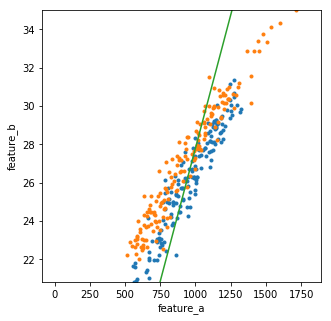

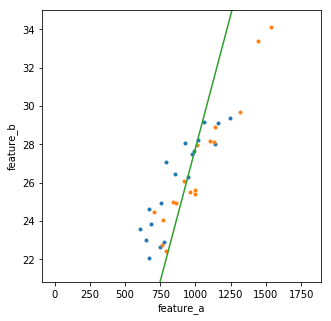

In [486]:
# logical regression
logistic_y_train2 = np.copy(y_train)
logistic_y_train2[y_train == number_a] = 0
logistic_y_train2[y_train == number_b] = 1

logistic_y_test2 = np.copy(y_test)
logistic_y_test2[y_test == number_a] = 0
logistic_y_test2[y_test == number_b] = 1

def get_weight_logistic(features, labels):
    weight_init = np.random.rand(2) # init weights to some random value.
    num_iterations = 100000 # set this to the number of iterations
    delta = 1e-2 # This may need to be adjusted
    step_size = 1e-2
    for i in range(num_iterations):
        log_loss = logistic_loss(features, labels, weight_init)
        gradient = get_gradient(features, labels, weight_init, delta, log_loss)
        weight_init -= step_size*gradient
        if (i % 10000 == 0):
            y_predicted = features@weight_init
            print("accuracy: ", accuracy_metrics(y_predicted, labels)) 
    return weight_init


weight_numerical_train = get_weight_logistic(X_features, logistic_y_train2)
visualize_model(X_features, logistic_y_train2, weight_numerical_train, y_train)
visualize_model(X_features, logistic_y_test2, weight_numerical_train, y_test)